In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm

In [2]:
#work around all those python directory crazyness in order to access the ab_testing module
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from ab_testing.variance_reduction import stratified_ttest

# Stratification in AB testing

bla bla bla explain the math based on CUPED paper

In [21]:
size = 10000

base = np.concatenate([
    norm(loc=0, scale=1).rvs(size=size),
    norm(loc=10, scale=1).rvs(size=size),
])
strata_base = np.concatenate([np.array([0] * size), np.array([1] * size)])
variant = np.concatenate([
    norm(loc=0.1, scale=1).rvs(size=size),
    norm(loc=10.1, scale=1).rvs(size=size),
])
strata_variant = strata_base.copy()

df_base = pd.DataFrame.from_dict(data={"value": base, "stratum": strata_base})
df_variant = pd.DataFrame.from_dict(data={"value": variant, "stratum": strata_variant})


df_base

,value,stratum
0,0.582496,0
1,-0.484479,0
2,0.121588,0
3,-0.177084,0
4,0.148300,0
...,...,...
19995,10.677670,1
19996,10.189405,1
19997,8.519759,1
19998,10.280292,1


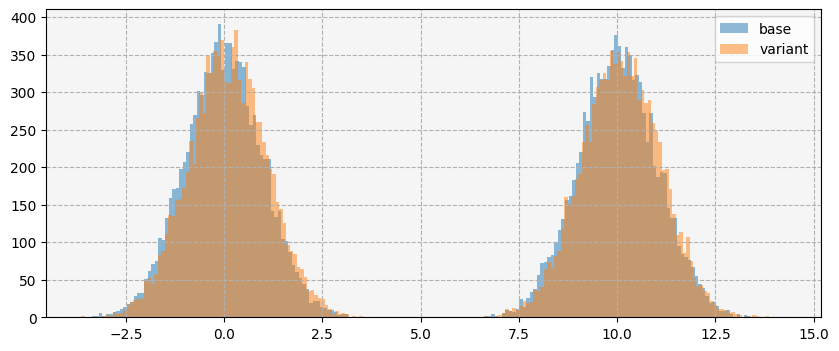

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.hist(df_base.value, bins=200, alpha=.5, label="base")
ax.hist(df_variant.value, bins=200, alpha=.5, label="variant")
ax.legend()
ax.grid(True, linestyle="--")
ax.set_facecolor("whitesmoke")
plt.show()

In [ ]:
def sample_sample_means_diff(df_base, df_variant, strsatified=False):
    pass